# Ensemble Train

- train last fc layer to combine two models (street view, top view)

In [1]:
#--
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace")
import map_dataset
import map_train
from models import *

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
#--- torch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
#--- loss functions
from utils.losses import LabelSmoothCrossEntropy, CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
#---
from lightning.fabric import Fabric
from lightning.fabric.loggers import CSVLogger, TensorBoardLogger
from torchmetrics.classification import Accuracy
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
import argparse
import yaml 
import timm
import numpy as np 
import time
import wandb
import random
import matplotlib.pyplot as plt
from rich.console import Console

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#--- all infos
inference_dict ={
    'models':[],
    'cfgs':[],
    'predictions':[],
    'labels':[]
}

#--- argparser
cfgs_names = ['finetune_5.yaml', 'finetune_8.yaml']
for cfg_name in cfgs_names:    
    parser = argparse.ArgumentParser()
    parser.add_argument('--cfg', type=str, default=os.path.join('./configs', cfg_name))
    args = parser.parse_args(args=[])
    cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))
    inference_dict['cfgs'].append(cfg)
    print("Model run version : ", cfg.RUN_VERSION)

Model run version :  15
Model run version :  18


In [3]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_data = os.listdir(train_path)
names_train, names_valid = train_test_split(names_data, test_size=0.1, random_state=1)

In [4]:
for cfg in inference_dict['cfgs']:   
    model = timm.create_model(
    cfg.MODEL,
    pretrained=True,
    num_classes=cfg.CLASSES_NUM )

    #--- data config and transform
    data_config = timm.data.resolve_model_data_config(model)
    data_transform = timm.data.create_transform(**data_config, is_training=False)

    inference_dict['models'].append(model)
    print("#------------------------------------")
    print(" Model Name : ",cfg.MODEL)

/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


In [5]:
ckpt_paths = [
            "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/15_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.65_epoch_8.pth",
            "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/18_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.7226_epoch_5.pth" ]

for i,model in enumerate(inference_dict['models']):
    model.load_state_dict(torch.load(ckpt_paths[i]))

In [6]:
train_set = map_dataset.Map_Dataset_v7(names_train,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="train") 
valid_set = map_dataset.Map_Dataset_v7(names_valid,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid")  

idx :  817


5 < Label > 
5 < 1 Model Prediction > 
tensor([[1.8201e-03, 1.1454e-03, 4.3376e-04, 5.0158e-04, 7.0792e-03, 5.0243e-01,
         4.8659e-01]], device='cuda:3', grad_fn=<SoftmaxBackward0>)


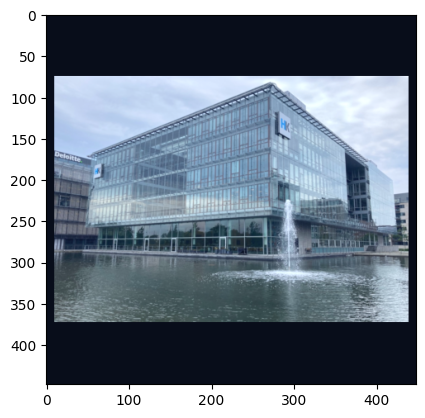

In [7]:
'''
#--- Single image for Visualization 
# A model : Cross-entropy loss with Street Voew 
# B model : Cross-entropy loss with Top Voew

'''
idx_ = random.randint(0,999)
print("idx : ", idx_)

dataset = valid_set

street_view = dataset.__getitem__(idx_)[0]
img_torch = street_view 
#RS_utils.torch_display(img_torch, False, True)

#--- inference
device = "cuda:3"


def infer_model(img_torch,model,loss_type):
    
    img_torch = img_torch.to(device)
    
    model = model.eval()
    model = model.to(device)
    img_torch = img_torch.unsqueeze(0)
    preds = model(img_torch)
    
    if loss_type == "CE":
        preds_ = preds.softmax(-1).argmax(-1)
    elif loss_type == "MSE" or loss_type == "MAE":
        preds_ = preds
    print(dataset.__getitem__(idx_)[-1], "< Label > ")
    print(preds_.item(), f"< {i} Model Prediction > ")
    #print(preds)
    print(preds.softmax(-1))
    
    img_torch = img_torch.squeeze(0)
    img = img_torch.clone() 
    
    # denormal
    img = ((img) * 0.22) + 0.5
    # [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    #-----
            
    img = img.permute(1,2,0).cpu()
    img = np.asarray(img)   
    plt.imshow(img)
        
            
#-- 
infer_model(img_torch,inference_dict['models'][0],"CE")

5 < Label > 
5 < 1 Model Prediction > 
tensor([[8.9960e-04, 4.4422e-04, 6.8995e-04, 1.2596e-03, 2.2189e-03, 8.2707e-01,
         1.6741e-01]], device='cuda:3', grad_fn=<SoftmaxBackward0>)


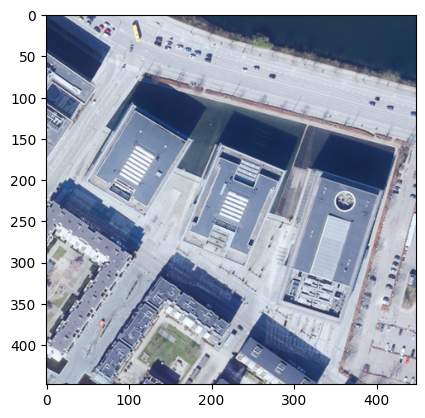

In [8]:
top_view = dataset.__getitem__(idx_)[1]
img_torch = top_view 

infer_model(img_torch,inference_dict['models'][1],"CE")

# Model Ensemble Train

In [9]:
import torch.nn as nn 

class EnsembleModel(nn.Module):

    '''
    - two models will be ensembled

    '''

    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(7 * 2, 7)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        out = torch.cat( (x1, x2), dim=1)
        out = self.classifier(out)
        return out

In [14]:
ensemble_model = EnsembleModel(inference_dict['models'][0], inference_dict['models'][1])

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    


print("Ensemble device : ", cfg.DEVICE)
ensemble_model = ensemble_model.to(cfg.DEVICE)
model = ensemble_model

Ensemble device :  cuda:1


# Training Pipes

In [11]:
trainloader = DataLoader(train_set, cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.NUM_WORKERS, pin_memory=True, drop_last=True)
testloader = DataLoader(valid_set, cfg.BATCH_SIZE, num_workers=cfg.NUM_WORKERS, pin_memory=True) 

In [12]:
if cfg.LOSS_FN =="MSE":
    train_loss_fn = torch.nn.MSELoss()
    val_loss_fn = torch.nn.MSELoss()
if cfg.LOSS_FN =="MAE":
    train_loss_fn = torch.nn.L1Loss()
    val_loss_fn = torch.nn.L1Loss()
elif cfg.LOSS_FN =="CE":     
    train_loss_fn = CrossEntropyLoss() 
    val_loss_fn = CrossEntropyLoss()

In [13]:
train_loss_fn

CrossEntropyLoss()

In [15]:
optimizer = AdamW(model.parameters(), cfg.LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2)

In [16]:
#--- Metric
metric_obj = RS_utils.Metric_Classification()

# Logger

- model => run version 15
- model => run version 18

In [30]:
#--- Online logger
wandb.init(project='MapYourCity')
model1 = inference_dict['cfgs'][0].RUN_VERSION
model2 = inference_dict['cfgs'][1].RUN_VERSION
wandb.run.name = f'Ensemble_Model_{model1}_{model2}'
wandb.run.save()

print("model 1 :",model1)
print("model 2 :",model2)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ericpark. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model 1 : 15 model2 18


In [33]:
cfg.FABRIC
print(cfg.FABRIC)

cfg.FABRIC = False
print(cfg.FABRIC)

False
False


In [34]:
#--- init fabric
if cfg.FABRIC: 
    fabric = Fabric(accelerator="cuda", devices=cfg.DEVICES, strategy="ddp")
    fabric.launch()
    

In [ ]:

for epoch in range(cfg.EPOCHS):
    
    accum_time = 0
    # Train 
    for iteration, (str_imgs,top_imgs, _ ,labels) in enumerate(trainloader):
        
        iter_start = time.time()
        
        if not cfg.FABRIC:
            top_imgs = top_imgs.to(cfg.DEVICE)
            labels = labels.to(cfg.DEVICE)
        #with autocast(enabled=cfg.AMP):    
        
        pred = model(top_imgs)
        optimizer.zero_grad()

        if cfg.LOSS_FN == "MSE" or cfg.LOSS_FN == "MAE" :
            pred = pred.squeeze(-1)
            pred = pred.to(torch.float32)
            labels = labels.to(torch.float32)
            loss = train_loss_fn(pred, labels)
        elif cfg.LOSS_FN =="CE":  
            loss = train_loss_fn(pred, labels)
        
        if cfg.FABRIC:
            fabric.backward(loss)
            optimizer.step()
        else:
            loss.backward()
            optimizer.step()        
        
        iter_end =time.time()
        iter_time = iter_end - iter_start
        accum_time += iter_time
        
        time_total = len(trainloader) * iter_time 
        time_remaining = time_total - accum_time
        
        log_dict=   { 
            "epoch" : epoch,
            "iteration" : iteration,
            "progress" : float(str(iteration / len(trainloader))[0:4]),
            "time_remaining" :  time.strftime("%H:%M:%S", time.gmtime(time_remaining)),
            "time_total" : time.strftime("%H:%M:%S", time.gmtime(time_total)) ,
            "loss" : float(str(loss.item())[0:6]),  
            "batch_size" : int(cfg.BATCH_SIZE),
            "lr" : optimizer.param_groups[0]['lr']
        }
        
        wandb.log(log_dict)
    #-- learning scheduler step 
    #scheduler.step()


    # Evaluation Metric

    if cfg.LOSS_FN == "CE":
        #-- evaluate last training batch
        predictions = torch.argmax(pred, -1).cpu()
        labels = labels.cpu()
        train_precision, train_recall, train_f1, train_accuracy  = metric_obj.classification_metrics(labels,predictions)
        
        #-- evaluate validation
        valid_precision, valid_recall, valid_f1, valid_accuracy = map_train.test_v4(testloader, model, val_loss_fn,cfg,metric_obj)
        valid_f1 = str(valid_f1)[0:6]

        log_dict_test = {
        "epoch" : epoch,
        "batch_size" : int(cfg.BATCH_SIZE),
        "lr" : optimizer.param_groups[0]['lr'],
        "train precision": train_precision,
        "train recall": train_recall,
        "train f1" : train_f1,
        "train accuracy" : train_accuracy,
        "valid_precision" : valid_precision,
        "valid_recall" : valid_recall,
        "valid_f1" : valid_f1,
        "valid_accuracy" : valid_accuracy}
        wandb.log(log_dict_test)
    
    elif cfg.LOSS_FN == "MSE" or cfg.LOSS_FN == "MAE":
        
        #-- evaluate validation
        regression_loss = map_train.test_v4(testloader, model, val_loss_fn,cfg,metric_obj)
        regression_loss = str(regression_loss)[0:6]

        log_dict_test = {
        "epoch" : epoch,
        "batch_size" : int(cfg.BATCH_SIZE),
        "lr" : optimizer.param_groups[0]['lr'],
        "loss type":cfg.LOSS_FN,
        "valid loss" :regression_loss}
        wandb.log(log_dict_test)

    
    #-- model save
    if cfg.LOSS_FN=="MSE" or cfg.LOSS_FN=="MAE":
        torch.save(model.state_dict(), os.path.join(cfg.SAVE_DIR, f"{cfg.RUN_VERSION}_{cfg.MODEL}_{cfg.LOSS_FN}_{regression_loss}_epoch_{epoch}.pth")) 
    else:
        torch.save(model.state_dict(), os.path.join(cfg.SAVE_DIR, f"Ensemble_Model_{model1}_{model2}_f1_{valid_f1}_epoch_{epoch}.pth"))
    
